## Display function

In [19]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np

def plot_roc_comparison(results_lists, names, results_original_roc):
    """
    Creates a plot comparing the performance of multiple classifier sets.
    Each set's performance is shown as a connected line of points.

    Args:
        results_lists (list): A list of lists of dictionaries. Each inner list contains
                              dictionaries with 'fpr' and 'tpr' keys.
        names (list): A list of strings, where each name corresponds to a list in results_lists.
        results_original_roc (dict): A dictionary for the baseline ROC curve, containing:
                                     - "name" (str): The name of the original curve.
                                     - "auc" (float): The pre-calculated AUC score.
                                     - "fpr" (array-like): The false positive rates.
                                     - "tpr" (array-like): The true positive rates.
    """
    # --- Input Validation ---
    if not results_lists or not names:
        print("No results or names provided to plot.")
        return
    if len(results_lists) != len(names):
        print("Error: The number of result lists must match the number of names.")
        return

    # --- Plotting Setup ---
    plt.figure(figsize=(11, 11))
    colors = ['red', 'green', 'purple', 'orange', 'cyan', 'magenta']

    # --- Plot each performance set ---
    for i, results_list in enumerate(results_lists):
        name = names[i]

        if not results_list:
            print(f"Skipping '{name}' as its result list is empty.")
            continue
            
        # Convert results to a pandas DataFrame for easy sorting
        df = pd.DataFrame(results_list)
        if 'fpr' not in df.columns or 'tpr' not in df.columns:
            print(f"Skipping '{name}' due to missing 'fpr' or 'tpr' keys in its data.")
            continue
            
        df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
        
        # Select a color for this set
        color = colors[i % len(colors)]
        
        # Calculate the Area Under the Curve for the connected points
        roc_auc = auc(df_sorted["fpr"], df_sorted["tpr"])

        # Plot the line connecting the points for this set
        plt.plot(df_sorted['fpr'], df_sorted['tpr'], color=color, lw=1.5,
                 alpha=0.8, label=f'{name} (AUC = {roc_auc:.2f})')

        # Plot the individual model points as a scatter plot
        plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c=color, marker='o', 
                    alpha=0.6, s=80, zorder=3)

    # --- Plot the original ROC curve for reference ---
    if results_original_roc:
        plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', lw=2.5,
                 label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # --- Final plot styling ---
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # "No-skill" line
    
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Comparison', fontsize=16)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Best ROC envelope

In [21]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [23]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [24]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

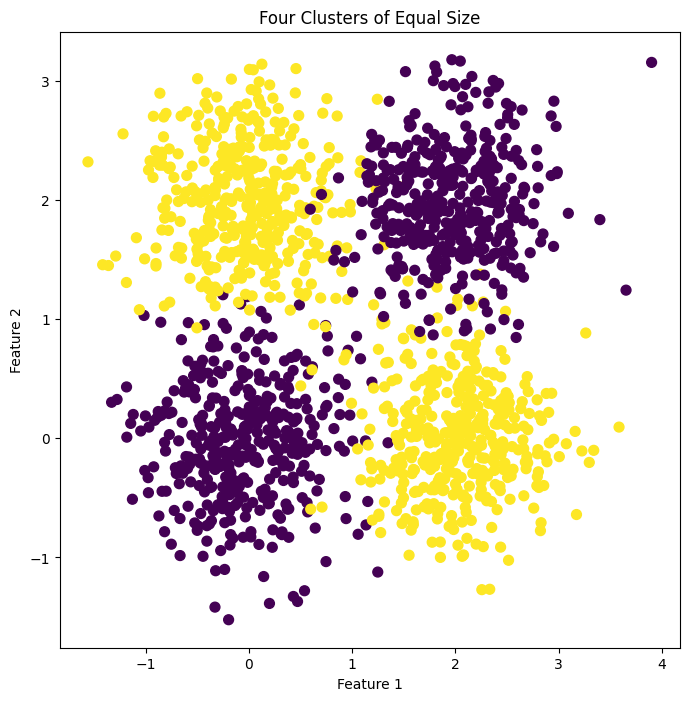

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [26]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data1")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [51]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
----------------------------------------------------

--- Starting Training for 1 epochs on train_loader ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-clf-epoch=00-v25.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-clf-epoch=00-v25.ckpt


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-clf-epoch=00-v25.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-clf-epoch=00-v25.ckpt ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4517
AUC: 0.4113
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.714167058467865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on Test Set ---

--- Confusion Matrix ---
[[215  85]
 [247  53]]

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.47      0.72      0.56       300
     Class 1       0.38      0.18      0.24       300

    accuracy                           0.45       600
   macro avg       0.42      0.45      0.40       600
weighted avg       0.42      0.45    

### Weighted ROC curve

In [28]:
NUM_CLASSIFIERS = 50
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        # 1. Instantiate the LightningModule
        model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE, pos_weight=pos_weight)
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=test_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




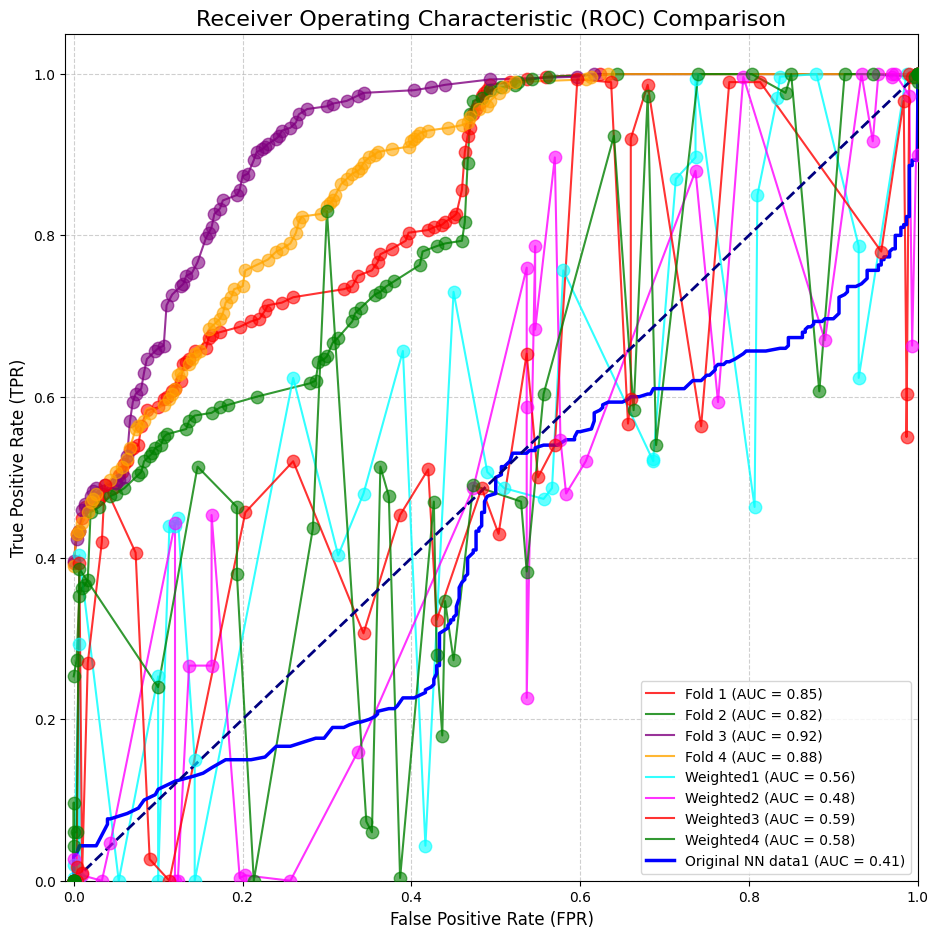

In [53]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [85]:
import numpy as np
import torch
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, classification_report

def predict_ensemble_and_evaluate(list_folds_best_models, test_loader, target_fpr):
    """
    Finds the best model snapshot from each fold based on a target FPR,
    performs ensemble prediction using hard voting, and evaluates the results.

    The main data structure, list_folds_best_models, is expected to be a 
    List of Lists of Dictionaries: List[List[Dict]].

    Args:
        list_folds_best_models (List[List[Dict]]): The nested list containing model snapshots for each fold.
        test_loader (DataLoader): DataLoader for the test dataset.
        target_fpr (float): The target False Positive Rate to determine thresholds.

    Returns:
        np.ndarray: Final ensemble predictions for the test set, or None if an error occurs.
    """
    # --- Part 1: Initial Setup and Extraction of True Labels ---
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    true_labels = []
    all_model_raw_preds = []
    optimal_thresholds = [] # This list will be populated below

    #print("Step 1: Extracting true labels from the test data loader...")
    with torch.no_grad():
        for _, labels in test_loader:
            true_labels.extend(labels.cpu().numpy())
    true_labels = np.array(true_labels).flatten()
    print(f"-> Extracted {len(true_labels)} labels.\n")

    # --- Part 2: Process Each Fold to Find the Best Model and Get Predictions ---
    
    #print("Step 2: Processing folds to find best models and get predictions...")
    
    for i, fold_run_data in enumerate(list_folds_best_models):
        
        best_snapshot_for_fold = None
        min_overall_fpr_diff = float('inf')

        for snapshot_info in fold_run_data:
            # Your excellent simplification is used here
            fpr_value = snapshot_info["fpr"]
            current_diff = abs(fpr_value - target_fpr)
            
            if current_diff < min_overall_fpr_diff:
                min_overall_fpr_diff = current_diff
                best_snapshot_for_fold = snapshot_info
        
        if best_snapshot_for_fold is None:
            print(f"Warning: Could not find a suitable model in Fold {i+1}. This fold will be skipped.")
            continue

        best_model = best_snapshot_for_fold["model"]
        if isinstance(best_model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{best_model}'")
            continue
        best_fpr = best_snapshot_for_fold["fpr"]
        best_threshold = best_snapshot_for_fold["threshold"]
        
        # ####################################################################
        # # CRITICAL FIX: Add the found threshold to the list for later use  #
        # ####################################################################
        optimal_thresholds.append(best_threshold)

        #print(f"\n- Fold {i+1}:")
        #print(f"  - Found best model snapshot. Closest FPR to {target_fpr} is {best_fpr:.4f}")
        #print(f"  - Using decision threshold: {best_threshold:.4f}")

        # Get raw predictions using this single best model for the fold
        best_model.to(device)
        best_model.current_test_threshold = best_threshold  # Set the threshold for this model
        best_model.eval()

        current_model_preds = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = torch.sigmoid(best_model(inputs))
                current_model_preds.extend(outputs.cpu().numpy())
        
        all_model_raw_preds.append(np.array(current_model_preds).flatten())

    # --- Part 3 & 4 (No changes needed here) ---

    if not all_model_raw_preds:
        print("\nError: No models were found to make predictions. Aborting.")
        return None

    #print("\nStep 3: Performing hard voting on collected predictions...")

    predictions_matrix = np.array(all_model_raw_preds)
    binary_predictions = np.zeros_like(predictions_matrix)

    
    for i in range(predictions_matrix.shape[0]):
        binary_predictions[i, :] = (predictions_matrix[i, :] >= optimal_thresholds[i]).astype(int)
    
    vote_counts = np.sum(binary_predictions, axis=0)
    num_models = predictions_matrix.shape[0]
    final_preds = (vote_counts > num_models / 2).astype(int)
    #print(f"-> Voting complete using {num_models} models.")

    #print("\nStep 4: Calculating Final Ensemble Performance Metrics...")

    #print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(true_labels, final_preds)
    try:
        tn, fp, fn, tp = cm.ravel()
        print(cm)
        # ... (your print statements for TN, FP, etc.) ...
        
        # --- Core Metrics ---
        # ... (your accuracy, precision calculations) ...
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        # ... (your print statements for metrics) ...
        
        # Store the calculated values
        final_tpr = tpr
        final_fpr = fpr

    except ValueError:
        print("\nCould not unpack confusion matrix (e.g., all predictions are of one class).\n")
        # In case of an error, both remain None

    #print("--- Classification Report ---")
    #report = classification_report(true_labels, final_preds, target_names=['Class 0', 'Class 1'], zero_division=0)
    #print(report)

    # MODIFIED RETURN STATEMENT: Return a tuple with both metrics
    return final_tpr, final_fpr

    

    

In [86]:
# Replace your main script block with this one.

# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        calculated_tpr, calculated_fpr = result_tuple
        if calculated_tpr is not None and calculated_fpr is not None:
            # Create a dictionary for each point and append it to the list
            point_dict = {'fpr': calculated_fpr, 'tpr': calculated_tpr}
            ensemble_results.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results or ensemble_results[0]['fpr'] > 0.0:
        ensemble_results.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results[-1]['fpr'] < 1.0 or ensemble_results[-1]['tpr'] < 1.0:
        ensemble_results.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
-> Extracted 600 labels.

[[300   0]
 [230  70]]
-> Extracted 600 labels.

[[295   5]
 [161 139]]
-> Extracted 600 labels.

[[297   3]
 [160 140]]
-> Extracted 600 labels.

[[300   0]
 [233  67]]
-> Extracted 600 labels.

[[300   0]
 [163 137]]
-> Extracted 600 labels.

[[300   0]
 [150 150]]
-> Extracted 600 labels.

[[295   5]
 [128 172]]
-> Extracted 600 labels.

[[295   5]
 [113 187]]
-> Extracted 600 labels.

[[294   6]
 [102 198]]
-> Extracted 600 labels.

[[294   6]
 [ 92 208]]
-> Extracted 600 labels.

[[291   9]
 [ 79 221]]
-> Extracted 600 labels.

[[289  11]
 [ 70 230]]
-> Extracted 600 labels.

[[287  13]
 [ 67 233]]
-> Extracted 600 labels.

[[255  45]
 [ 56 244]]
-> Extracted 600 labels.

[[253  47]
 [ 53 247]]
-> Extracted 600 labels.

[[248  52]
 [ 46 254]]
-> Extracted 600 labels.

[[245  55]
 [ 37 263]]
-> Extracted 600 labels.

[[241  59]
 [ 32 268]]
-> Extracted 600 labels.

[[241  59]
 [ 28 272]


--- Plotting all ROC curves for comparison ---


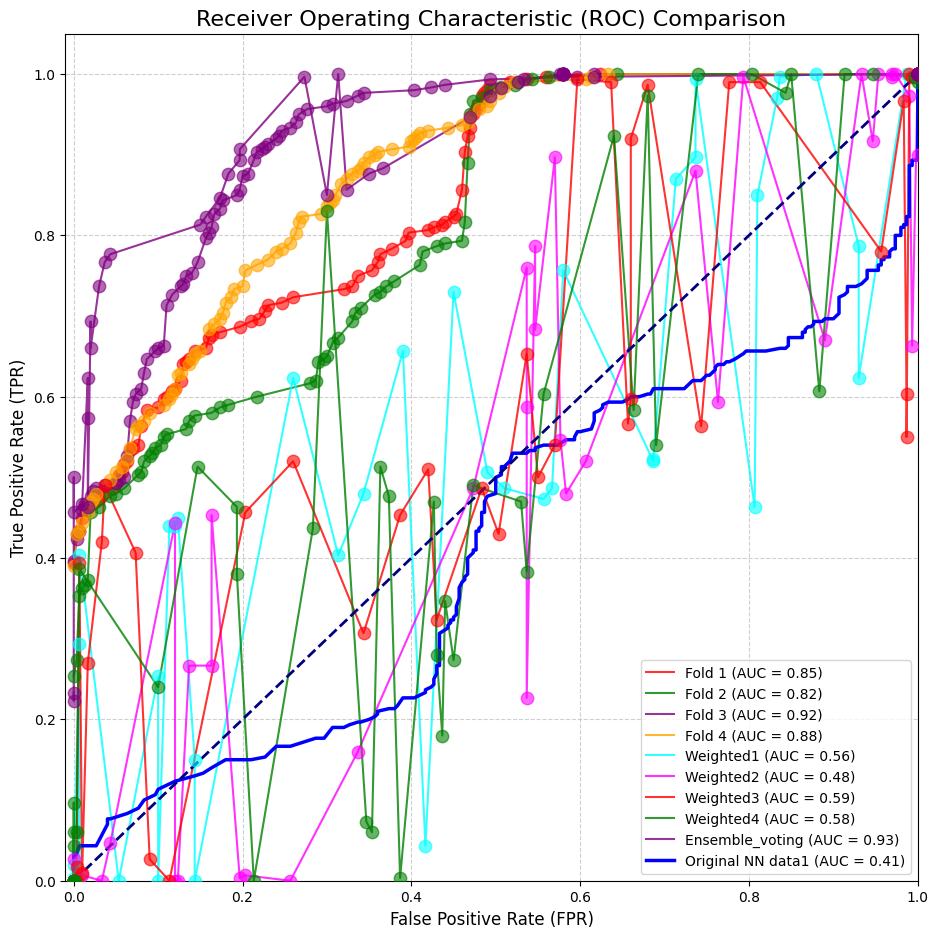

In [88]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting"],
    results_original_roc=results_original_roc
)

## Check performances

In [46]:
predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader,
    target_fpr=0.1
)

Step 1: Extracting true labels from the test data loader...
-> Extracted 600 labels.

Step 2: Processing folds to find best models and get predictions...

- Fold 1:
  - Found best model snapshot. Closest FPR to 0.1 is 0.1000
  - Using decision threshold: 0.4829

- Fold 2:
  - Found best model snapshot. Closest FPR to 0.1 is 0.1033
  - Using decision threshold: 0.5410

- Fold 3:
  - Found best model snapshot. Closest FPR to 0.1 is 0.1000
  - Using decision threshold: 0.4238

- Fold 4:
  - Found best model snapshot. Closest FPR to 0.1 is 0.1067
  - Using decision threshold: 0.5356

Step 3: Performing hard voting on collected predictions...
-> Voting complete using 4 models.

Step 4: Calculating Final Ensemble Performance Metrics...

--- Confusion Matrix ---
[[300   0]
 [150 150]]
--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.67      1.00      0.80       300
     Class 1       1.00      0.50      0.67       300

    accuracy     

## Check performance on test1 and test2

In [ ]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs

In [ ]:
opt_classifier = roc_performance_tester(list_folds_best_models[0], test_loader)

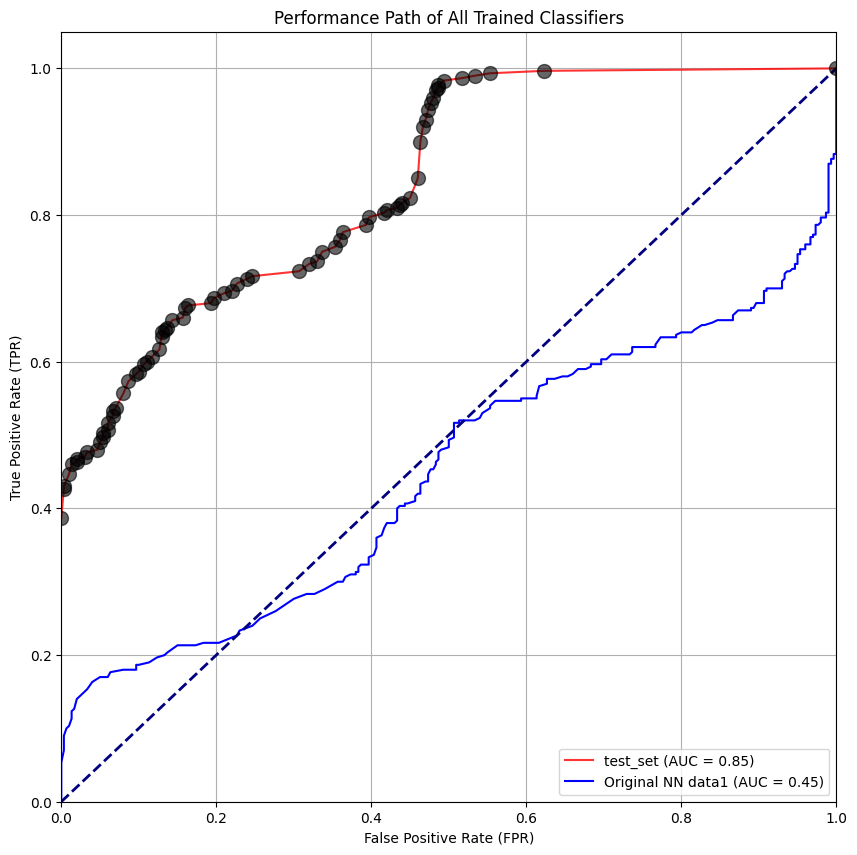

In [34]:
plot_roc_connected_points(opt_classifier, results_original_roc, name="test_set")